In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import os
import sys
import pathlib
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import json



%matplotlib inline  

In [2]:
# Set data input folder
input_folder = "inputs"

# Set output folder, subfolder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)

In [3]:
# Import the guide-level profiles
df_guide = pd.read_csv("outputs/20240202_6W_CP498_SABER_Pilot_HeLa_guide_normalized_merged_feature_select_median_ALLWELLS_cp.csv.gz")

# Load expression data 
with open("outputs/HeLa_CP_CCLE_expression_summary.json") as f:
    express = json.load(f)
    zero_tpm_list = express['zero_tpm']
    expressed_gene_list = express['expressed_genes']

# subset the profiles to only expressed genes
gene_list = express['expressed_genes']
df_genes = df_guide[(df_guide['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(gene_list))]

# Create a dattaframe of only features without metadata
feature_df = df_genes.drop(['Metadata_Foci_Barcode_MatchedTo_GeneCode','Metadata_Foci_Barcode_MatchedTo_Barcode'],axis = 1).reset_index(drop=True)
feature_df

,Metadata_Foci_Barcode_MatchedTo_GeneCode,Metadata_Foci_Barcode_MatchedTo_Barcode,Cells_AreaShape_BoundingBoxMinimum_X,Cells_AreaShape_BoundingBoxMinimum_Y,Cells_AreaShape_CentralMoment_0_1,Cells_AreaShape_CentralMoment_0_3,Cells_AreaShape_CentralMoment_1_0,Cells_AreaShape_CentralMoment_1_2,Cells_AreaShape_CentralMoment_1_3,Cells_AreaShape_CentralMoment_2_1,...,Nuclei_Texture_InfoMeas1_Mito_5_01_256,Nuclei_Texture_InfoMeas1_Mito_5_03_256,Nuclei_Texture_InfoMeas1_WGA_10_00_256,Nuclei_Texture_InfoMeas1_WGA_5_00_256,Nuclei_Texture_InfoMeas1_WGA_5_02_256,Nuclei_Texture_InfoMeas2_DAPI_Painting_10_03_256,Nuclei_Texture_InfoMeas2_Mito_5_02_256,Nuclei_Texture_InfoMeas2_Phalloidin_5_00_256,Nuclei_Texture_SumAverage_DAPI_Painting_10_03_256,Nuclei_Texture_SumVariance_Mito_10_03_256
0,AARS2,AAAGGCGGCCCTCACGGCCG,-0.049695,-0.007310,0.068068,0.282360,-0.716255,0.005817,0.218232,-0.154402,...,0.327775,0.296771,0.487940,0.305170,0.191921,0.154430,-0.252812,-0.493225,0.296880,-0.279502
1,AARS2,AGCAAACTGGGGTCGCCGCG,-0.056370,0.034850,-0.129720,0.102712,-0.227415,0.196801,0.005880,-0.064720,...,-0.125585,-0.222343,-0.267363,-0.014090,-0.084492,0.081421,0.078580,0.115098,-0.156265,-0.170241
2,AARS2,CCAACTTCTACGCAGAACAG,-0.160030,-0.091385,0.148568,-0.216035,0.034805,0.163045,0.066160,0.356585,...,-0.402410,-0.458070,-0.447815,-0.317605,-0.398200,0.132896,0.480540,0.317265,-0.341360,0.114366
3,AARS2,GCTGAGCCAGTTCAGAAGCA,0.286901,0.142030,-0.313969,-0.053498,0.153567,-0.259566,0.012046,-0.067856,...,0.165980,-0.044400,-0.000590,0.041017,0.098723,0.022136,-0.142982,-0.108239,-0.352795,-0.215195
4,AARSD1,ACCTCCGCTCCCAATCTACC,-0.135745,-0.062917,-0.331497,0.277325,0.218805,0.064993,-0.232255,-0.474220,...,0.639800,0.435405,0.689870,0.815490,0.522225,-0.641835,-0.834870,-0.789625,-0.769190,-0.571055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,nontargeting,TAAGATCCGCGGGTGGCAAC,-0.471880,0.069689,0.247578,-0.353750,-0.685932,-0.330715,-0.401865,0.184790,...,0.359865,0.634615,0.465790,0.498780,0.270355,0.246790,-0.308400,-0.426650,0.200284,-0.234015
2396,nontargeting,TCCCGGTTGGTGAACGATAC,0.023480,-0.463288,0.601885,0.030910,0.374675,-0.112565,0.301557,-0.650605,...,0.656175,0.597540,0.525310,0.580275,0.617890,0.059865,-0.553425,-0.592625,-0.313280,-0.296670
2397,nontargeting,TGCCGTGAAAAGACGCTGCG,-0.513425,-0.240830,0.340108,0.132513,-0.012648,0.194555,0.042534,-0.164266,...,0.235540,0.400525,0.278735,0.500875,0.429855,-0.129978,-0.430115,-0.451555,-0.036847,-0.352740
2398,nontargeting,TGGCCACGAATTCCGCCGCC,-0.011335,-0.114445,0.042562,-0.008606,0.443205,0.138462,0.008197,0.031328,...,0.500430,0.425680,0.443780,0.492115,0.476090,0.398430,-0.498765,-0.494330,0.441350,-0.380610


In [11]:
n_features = len(feature_df.columns)
model = PCA(n_components = n_features).fit(feature_df)
X_pc = model.transform(feature_df)

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component

initial_feature_names = list(feature_df.columns)

most_important = {}
for i in range(n_pcs):
    temp = np.abs(model.components_[i]).argsort()
    temp = temp[::-1] 
    most_important['PC{}'.format(i+1)] = [{initial_feature_names[temp[j]]: np.abs(model.components_[i])[temp[j]]} for j in range(n_features)]
    

len(most_important)

603

In [12]:
ratios = model.explained_variance_ratio_
feature_dic = {}
for count, key in enumerate(most_important.keys()):
    for c, k in enumerate(most_important[key]):
        value = list(k.values())[0] * ratios[count]
        if list(k.keys())[0] in feature_dic.keys():
            feature_dic[list(k.keys())[0]].append(value)
        else:
            feature_dic[list(k.keys())[0]] = [value]
len(feature_dic)

603

In [13]:
feature_scores = {}
added_values = 0
for feature in feature_dic.keys():
    feature_scores[feature] = sum(feature_dic[feature])
    added_values += sum(feature_dic[feature])
print(added_values)

feature_scores_df = pd.DataFrame.from_dict(feature_scores, orient='index')
len(feature_scores)

18.777289979798788


603

In [20]:
feature_scores_df.sort_values(0,ascending = False).tail(10)

,0
Nuclei_AreaShape_CentralMoment_1_2,0.016575
Cytoplasm_AreaShape_CentralMoment_0_3,0.016414
Cytoplasm_AreaShape_NormalizedMoment_1_3,0.016368
Cells_AreaShape_NormalizedMoment_2_1,0.016100
Cytoplasm_AreaShape_Orientation,0.015956
Cells_AreaShape_Orientation,0.015876
Cytoplasm_AreaShape_NormalizedMoment_3_1,0.015707
Cells_AreaShape_BoundingBoxMinimum_X,0.015652
Cytoplasm_AreaShape_NormalizedMoment_3_3,0.015332
Cells_AreaShape_InertiaTensor_1_0,0.015135


In [21]:
feature_scores_df.sort_values(0,ascending = False).head(10)

,0
Cytoplasm_Correlation_K_Mito_DAPI_Painting,0.040278
Cells_Texture_Contrast_ConA_20_01_256,0.040150
Cytoplasm_Correlation_Correlation_ConA_DAPI_Painting,0.040121
Cytoplasm_Intensity_IntegratedIntensityEdge_DAPI_Painting,0.040074
Nuclei_Texture_InfoMeas2_DAPI_Painting_10_03_256,0.040040
Cytoplasm_Intensity_MeanIntensityEdge_Mito,0.039929
Nuclei_RadialDistribution_FracAtD_ConA_4of4,0.039908
Nuclei_AreaShape_SpatialMoment_2_3,0.039759
Cells_RadialDistribution_MeanFrac_mito_tubeness_13of20,0.039467
Cells_Texture_Correlation_Phalloidin_5_01_256,0.039364


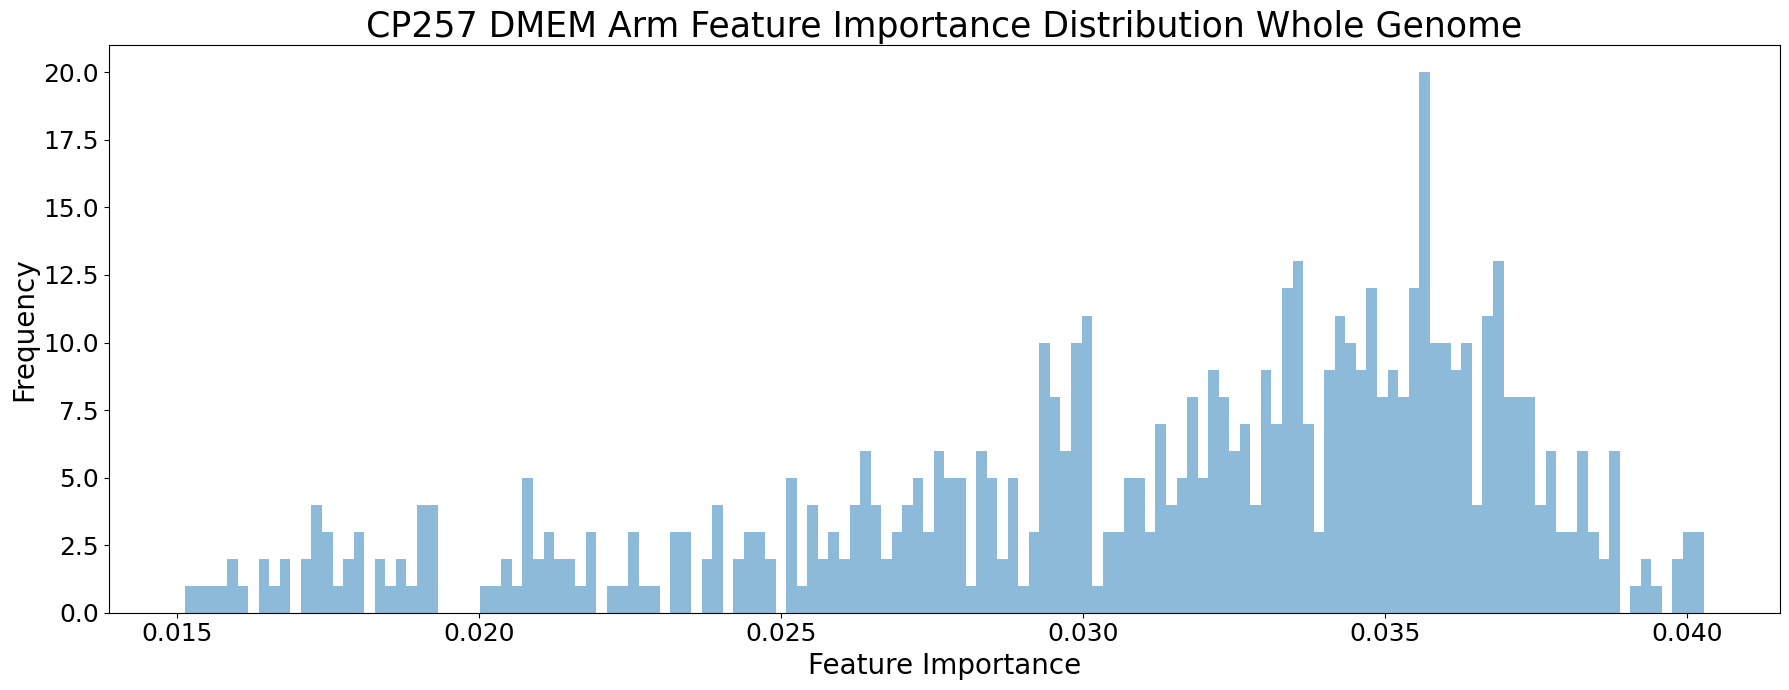

In [16]:
fig, ax = plt.subplots(figsize=(18,7))

feature_scores_df.plot.hist(bins=int(576/4),color='tab:blue',alpha=0.5,ax=ax)


ax.set_title('CP257 DMEM Arm Feature Importance Distribution Whole Genome', fontdict= {'fontsize':25})
ax.set_xlabel('Feature Importance', fontdict= {'fontsize':20})
plt.xticks(fontsize=18)
ax.set_ylabel('Frequency', fontdict= {'fontsize':20})
plt.yticks(fontsize=18)
ax.get_legend().remove()
plt.tight_layout()
#ax.figure.savefig('cp257_dmem_feature_variation_importance_distribution_whole_genome.png', dpi=200,facecolor='w', edgecolor='w')
